Lekhana Devi Akuti, 300969345
Final Project CSCI 167

This project focuses on training a Deep Q-Network (DQN) agent to solve the LunarLander-v3 environment, a classic reinforcement learning problem where a spacecraft must land safely on a platform. The agent learns to make decisions by interacting with the environment, observing rewards, and improving its policy over time. 
Using PyTorch, I designed a neural network to approximate Q-values for each action, enabling the agent to evaluate its choices in various states. Key features, like the lander's position, velocity, and leg contact, were scaled and preprocessed for efficient learning. Techniques like experience replay and epsilon-greedy exploration ensured stable and balanced learning.
Hyperparameters such as the learning rate, batch size, and discount factor were carefully tuned for optimal performance. After training over 1000 episodes, the agent demonstrated a significant improvement in its ability to land safely, balancing exploration and exploitation. While the model showed strengths like consistent learning and adaptability, it also faced challenges such as slow convergence and reward variability, suggesting potential areas for future enhancements.

For this project, I used several libraries to make the implementation easier and more efficient. NumPy (numpy as np) helped with handling numbers and arrays, which were crucial for working with states and actions. Gymnasium (gymnasium as gym) provided the LunarLander-v3 environment, a great simulation for training and testing the model. PyTorch (torch and its modules like torch.nn and torch.optim) was used to build and train the neural network because it is powerful and easy to use. The random library and deque from collections were used to handle randomness and store experiences for replay, which is key in reinforcement learning. I used pandas (pd) to organize and analyze data, Matplotlib (plt) to create graphs showing how rewards changed over time, and MinMaxScaler from scikit-learn to scale the data so that it was consistent and ready for training.

In [ ]:
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

I initialized the LunarLander-v3 environment from OpenAI Gym because it’s a great way to test how well an agent can learn to land a spacecraft. I used render_mode="human" so I could watch the agent’s actions in real time, which helped me understand its behavior and make adjustments as needed.

In [3]:
# Initialize the LunarLander environment
env = gym.make("LunarLander-v3", render_mode="human")  # Use RGB array for frame rendering


I created a ReplayBuffer class to help the agent learn more effectively by storing its past experiences. This buffer holds the agent’s interactions with the environment, such as states, actions, and rewards, in a queue with a maximum capacity of 10,000. Using this, the agent doesn’t only learn from recent experiences but samples a batch of past ones during training. This approach, called experience replay, improves learning stability and efficiency by breaking correlations in consecutive data. It also ensures the agent learns from a diverse range of situations, helping it develop better decision-making skills.

In [15]:
# Replay Buffer Setup
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def size(self):
        return len(self.buffer)

In [16]:
# Initialize the replay buffer
replay_buffer = ReplayBuffer()

In [17]:
# Data collection parameters
n_episodes = 1000  # Number of episodes to collect data from

The collect_data() function is where I gathered experiences for training the agent. For each episode, I reset the environment and took random actions to explore it. As the agent interacted with the environment, I stored each experience—state, action, reward, next state, and whether the episode was finished—in the replay buffer. This allowed the agent to learn from past experiences. After each episode, I displayed the total reward to track how well the agent was performing. This process was crucial for generating the data needed to train the model.

In [18]:
# Function to collect data from the environment
def collect_data():
    for episode in range(n_episodes):
        state, _ = env.reset()  # Reset the environment
        state = np.array(state)  # Convert state to numpy array if needed
        done = False
        total_reward = 0

        while not done:
            action = env.action_space.sample()  # Random action (you can use a policy here later)
            next_state, reward, done, _, _ = env.step(action)  # Take a step in the environment
            next_state = np.array(next_state)  # Convert next state to numpy array

            # Store the experience (state, action, reward, next_state, done)
            replay_buffer.add((state, action, reward, next_state, done))

            state = next_state  # Move to the next state
            total_reward += reward

        print(f"Episode {episode + 1}/{n_episodes}, Total Reward: {total_reward}")

# Collect data from the environment
collect_data()   


Episode 1/1000, Total Reward: -280.93208477700944
Episode 2/1000, Total Reward: -103.90709762230242
Episode 3/1000, Total Reward: -206.6179044055778
Episode 4/1000, Total Reward: -277.01805697537986
Episode 5/1000, Total Reward: -83.58040587451829
Episode 6/1000, Total Reward: -282.36446691569813
Episode 7/1000, Total Reward: -103.95716151813572
Episode 8/1000, Total Reward: -163.2177679675059
Episode 9/1000, Total Reward: -115.95617461634845
Episode 10/1000, Total Reward: -75.93695235976756
Episode 11/1000, Total Reward: -90.12414094253627
Episode 12/1000, Total Reward: -239.21329576241095
Episode 13/1000, Total Reward: -112.99448744014107
Episode 14/1000, Total Reward: -317.99141427490895
Episode 15/1000, Total Reward: -165.95784745874624
Episode 16/1000, Total Reward: -132.31369599200792
Episode 17/1000, Total Reward: -261.17540144671227
Episode 18/1000, Total Reward: -87.55083536940822
Episode 19/1000, Total Reward: -337.54304356997983
Episode 20/1000, Total Reward: -254.5149464365

In this part of the code, I extracted the data stored in the replay buffer to separate the different components of each experience, such as the state, action, reward, next state, and whether the episode was done. By looping through the experiences in the replay buffer, I created individual lists for each component. These lists—states, actions, rewards, next_states, and dones—are essential for training the model. This extraction helps organize the data in a way that is easier to use when updating the Q-values during training.

In [19]:
# Extract the data from the replay buffer
states = []
actions = []
rewards = []
next_states = []
dones = []
# Loop through the replay buffer and separate each element
for experience in replay_buffer.buffer:
    state, action, reward, next_state, done = experience
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    next_states.append(next_state)
    dones.append(done)


In this part of the code, I converted the lists of states, actions, rewards, next states, and dones into NumPy arrays. This step is important because NumPy arrays allow for more efficient mathematical operations, which are crucial during model training. Working with arrays instead of lists helps in optimizing the data processing, especially when performing operations like matrix multiplications or calculating gradients in neural networks. By converting the data into arrays, I ensure it's in the correct format for further steps like model training.

In [20]:

# Convert the lists to numpy arrays
states = np.array(states)
actions = np.array(actions)
rewards = np.array(rewards)
next_states = np.array(next_states)
dones = np.array(dones)


In [21]:
# Proceed with analysis
# 1. Describing the states
states_df = pd.DataFrame(states, columns=[f"state_{i}" for i in range(states.shape[1])])


In [22]:
# 2. Feature summary for states
print("States summary:")
print(states_df.describe())


States summary:
            state_0       state_1       state_2       state_3       state_4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      -0.006537      0.995139      0.024442     -0.672127     -0.072524   
std        0.295369      0.459925      0.618990      0.495625      0.480675   
min       -0.992770     -0.343311     -1.637790     -2.143489     -2.380465   
25%       -0.154137      0.661976     -0.462388     -1.069353     -0.265697   
50%       -0.004427      1.125382      0.030961     -0.681478     -0.016175   
75%        0.137720      1.387726      0.502165     -0.306195      0.133255   
max        0.998845      1.632116      1.776570      0.522514      3.150390   

            state_5       state_6       state_7  
count  10000.000000  10000.000000  10000.000000  
mean      -0.040784      0.015000      0.008100  
std        0.358842      0.121559      0.089639  
min       -5.733648      0.000000      0.000000  
25%       -0.189432   

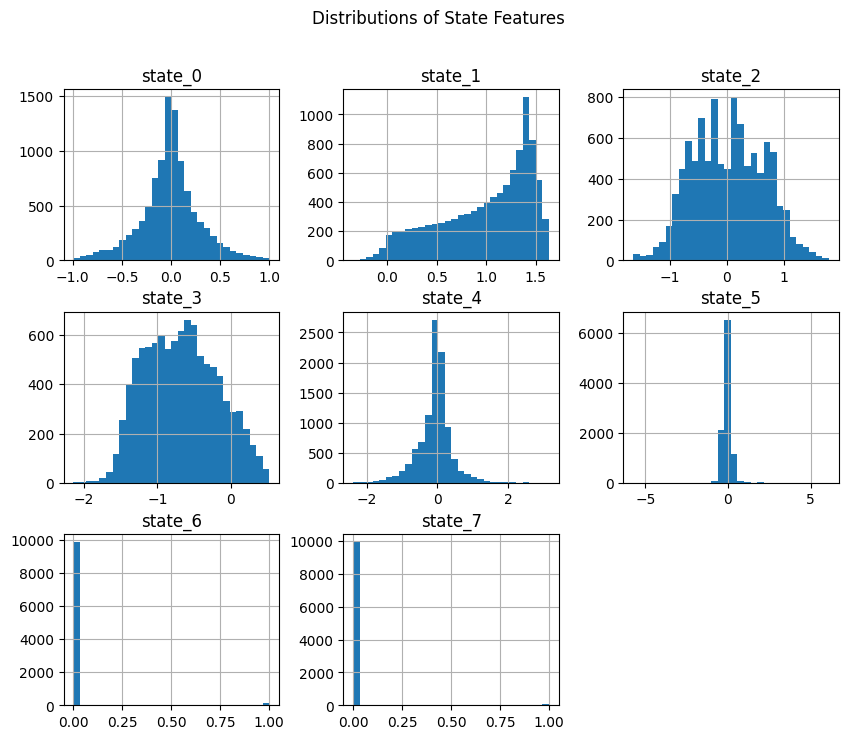

In [23]:
# 3. Plotting the distribution of each state feature
states_df.hist(bins=30, figsize=(10, 8))
plt.suptitle("Distributions of State Features")
plt.show()

In [24]:
# 4. Analyzing action distribution
action_counts = pd.Series(actions).value_counts()
print("\nAction distribution:")
print(action_counts)


Action distribution:
3    2606
0    2498
1    2463
2    2433
Name: count, dtype: int64


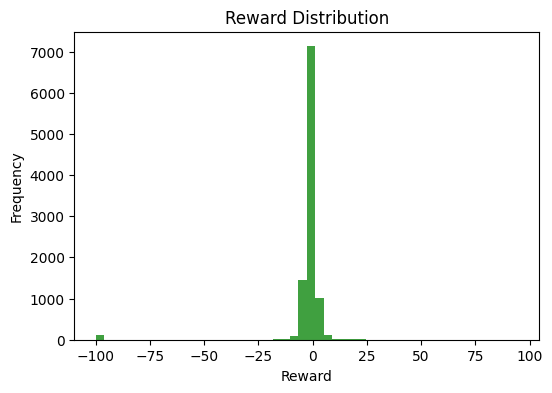

In [25]:
# 5. Reward distribution
plt.figure(figsize=(6, 4))
plt.hist(rewards, bins=50, alpha=0.75, color='g')
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()

In [26]:
# 6. Done flag distribution
done_counts = pd.Series(dones).value_counts()
print("\nDone flag distribution:")
print(done_counts)


Done flag distribution:
False    9890
True      110
Name: count, dtype: int64


In [27]:
# 7. Feature scaling (Preprocessing)
# States are continuous, and we might need to scale them for neural network training.
# Min-Max scaling to normalize states between 0 and 1
scaler = MinMaxScaler()
states_scaled = scaler.fit_transform(states_df)

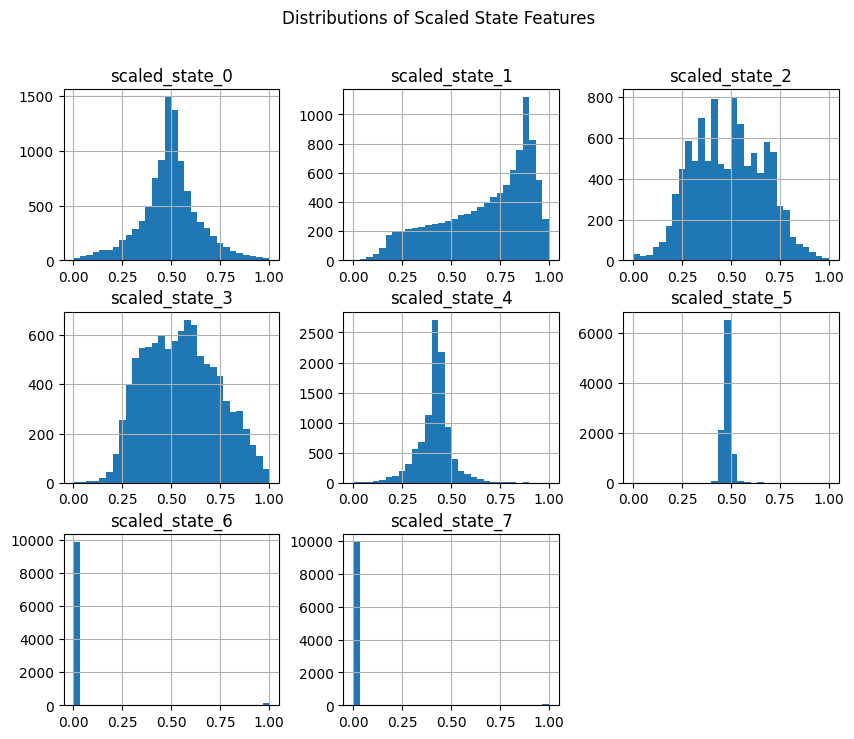

In [28]:
# 8. Checking if scaling worked (plotting a scaled state feature distribution)
states_scaled_df = pd.DataFrame(states_scaled, columns=[f"scaled_state_{i}" for i in range(states_scaled.shape[1])])
states_scaled_df.hist(bins=30, figsize=(10, 8))
plt.suptitle("Distributions of Scaled State Features")
plt.show()


In this part of the code, I defined a simple deep Q-network (DQN) model for the LunarLander task. The model consists of two fully connected layers. The first layer (fc1) takes the state input and transforms it into a 64-dimensional space. The second layer (fc2) maps the output of the first layer to the number of possible actions the agent can take. I chose this simplified architecture with fewer neurons to keep things computationally efficient while still allowing the model to learn useful features from the environment. The use of ReLU activation after the first layer helps the model introduce non-linearity, allowing it to learn complex relationships. This setup is intentionally kept simple, which helps focus on the core concept of applying deep reinforcement learning to the LunarLander environment.

In [46]:
# Define the simplified DQN model for LunarLander
class SimpleDQN(nn.Module):
    def __init__(self, n_states, n_actions):
        super(SimpleDQN, self).__init__()
        self.fc1 = nn.Linear(n_states, 64)  # Fewer neurons
        self.fc2 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In this part of the code, I defined the hyperparameters for the DQN model. The state space has 8 features (n_states = 8), and there are 4 possible actions (n_actions = 4). I set the learning rate (learning_rate = 0.005) to balance between fast learning and stability. The gamma value (gamma = 0.99) encourages the agent to consider future rewards. Epsilon (epsilon = 1.0) starts with full exploration, and decays over time (epsilon_decay = 0.995) to shift towards exploitation. I set the batch size (batch_size = 32) for efficient training and chose 1000 episodes (n_episodes = 1000) with a max of 500 steps per episode (max_steps = 500) to ensure sufficient learning.

In [47]:
# Hyperparameters
n_states = 8  # LunarLander state has 8 features
n_actions = 4  # LunarLander has 4 discrete actions
learning_rate = 0.005
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
batch_size = 32
n_episodes = 1000
max_steps = 500

In this part, I initialized two neural networks: the policy_net and the target_net. Both networks are instances of the SimpleDQN class that I defined earlier, and they are both set to have the same number of input states (n_states = 8) and output actions (n_actions = 4). The policy_net is the network that learns and makes decisions during training, while the target_net is used to compute the target Q-values during the learning process. I initialized the target_net with the same weights as policy_net by loading its state dictionary, ensuring that both networks start with the same parameters.

In [48]:
# Initialize networks
policy_net = SimpleDQN(n_states, n_actions)
target_net = SimpleDQN(n_states, n_actions)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [49]:
# Replay buffer
replay_buffer = deque(maxlen=5000)

In this section, I implemented the training loop for the DQN model. For each episode, I reset the environment and started with the initial state, which is then converted into a tensor. The loop runs for a maximum of 500 steps or until the agent reaches a terminal state. During each step, I used the epsilon-greedy strategy to choose an action: with probability epsilon, the agent takes a random action to explore, and with probability 1 - epsilon, the agent selects the action with the highest Q-value from the policy_net. After performing the action, I store the state, action, reward, next state, and done flag in the replay buffer.
The model trains when the replay buffer has enough experiences (greater than the batch size). I sampled a random batch from the buffer and computed the target Q-values using the Bellman equation. Then, I computed the predicted Q-values from the policy_net and used the loss between the predicted and target Q-values to update the policy_net parameters via backpropagation.
After each episode, I decayed the epsilon value to reduce exploration over time. I also periodically updated the target_net by copying the parameters from the policy_net to ensure stable training. The training progress is printed every 10 episodes, showing the total reward and the current value of epsilon. This loop continues for 1000 episodes.

In [50]:
# Training loop
for episode in range(n_episodes):
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor and add batch dimension
    total_reward = 0

    for step in range(max_steps):
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                action = torch.argmax(policy_net(state)).item()

        # Perform action
        next_state, reward, done, _, _ = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)  # Convert to tensor

        # Store transition in replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        total_reward += reward

        # Update state
        state = next_state

        # Train model if replay buffer has enough samples
        if len(replay_buffer) > batch_size:
            # Sample mini-batch from replay buffer
            batch = random.sample(replay_buffer, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            states = torch.cat(states)
            next_states = torch.cat(next_states)
            actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32)
            dones = torch.tensor(dones, dtype=torch.float32)

            # Compute target Q-values
            q_targets = rewards + gamma * torch.max(target_net(next_states), dim=1)[0] * (1 - dones)

            # Compute predicted Q-values
            q_values = policy_net(states).gather(1, actions).squeeze()


        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Update target network periodically
    if episode % 10 == 0:
        target_net.load_state_dict(policy_net.state_dict())
        print(f"Episode {episode}/{n_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

print("Training complete!")

Episode 0/1000, Total Reward: -132.36834520045858, Epsilon: 0.995
Episode 10/1000, Total Reward: -537.1638345610577, Epsilon: 0.946
Episode 20/1000, Total Reward: -86.59897620359892, Epsilon: 0.900
Episode 30/1000, Total Reward: -204.2108012135699, Epsilon: 0.856
Episode 40/1000, Total Reward: -114.15521735328505, Epsilon: 0.814
Episode 50/1000, Total Reward: -210.21851863297732, Epsilon: 0.774
Episode 60/1000, Total Reward: -191.05424120536378, Epsilon: 0.737
Episode 70/1000, Total Reward: -101.63234920848474, Epsilon: 0.701
Episode 80/1000, Total Reward: -119.29571519175221, Epsilon: 0.666
Episode 90/1000, Total Reward: -369.6410733096261, Epsilon: 0.634
Episode 100/1000, Total Reward: -160.3061348662362, Epsilon: 0.603
Episode 110/1000, Total Reward: -74.15166172797257, Epsilon: 0.573
Episode 120/1000, Total Reward: -146.27788408284783, Epsilon: 0.545
Episode 130/1000, Total Reward: -114.18348592474747, Epsilon: 0.519
Episode 140/1000, Total Reward: -112.21014553096188, Epsilon: 0.4

In this section, I created a function to evaluate the performance of the trained DQN model in the LunarLander environment. The function evaluate_model runs for a specified number of episodes (default is 1000). During each episode, the agent selects actions based on the policy network (policy_net). The agent’s actions are determined using the torch.argmax() function, which picks the action with the highest Q-value predicted by the network.

For each episode, I track the cumulative reward and the number of steps taken until the agent reaches a terminal state (done flag). If rendering is enabled and the episode is one of the first three, the environment's frames are displayed using matplotlib. This helps visualize how the agent is performing in the environment.

After each episode, I append the episode's total reward to a list. At the end of the evaluation, I calculate and print several statistics: the average reward, the standard deviation of the rewards, the best reward in any episode, and the worst reward in any episode. These statistics help assess how well the agent is performing across multiple episodes.

Finally, I call the evaluate_model function to run the evaluation with the trained model, setting the render parameter to False for faster evaluation

In [53]:
def evaluate_model(env, policy_net, n_episodes= 1000, render=False):
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)  # Convert state to tensor
        episode_reward = 0
        steps = 0

        while True:
            # Render the environment only if specified
            if render and episode < 3:  # Render only the first 3 episodes
                frame = env.render()
                plt.imshow(frame)
                plt.axis('off')
                plt.pause(0.001)
            
            # Select action using the trained policy
            with torch.no_grad():
                action = torch.argmax(policy_net(state)).item()
            
            # Perform action
            next_state, reward, done, _, _ = env.step(action)
            state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)
            episode_reward += reward
            steps += 1
            
            if done:
                break

        # Store rewards and print episode stats
        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward:.2f}, Steps = {steps}")

    # Calculate overall statistics
    avg_reward = np.mean(total_rewards)
    std_reward = np.std(total_rewards)
    print(f"\nAverage Reward: {avg_reward:.2f}")
    print(f"Reward Standard Deviation: {std_reward:.2f}")
    print(f"Best Episode Reward: {np.max(total_rewards):.2f}")
    print(f"Worst Episode Reward: {np.min(total_rewards):.2f}")

    return total_rewards

# Evaluate the model
env = gym.make("LunarLander-v3", render_mode="rgb_array")
evaluate_model(env, policy_net, n_episodes=1000, render=False)  # Render off for speed



Episode 1: Reward = -81.66, Steps = 54
Episode 2: Reward = -135.09, Steps = 58
Episode 3: Reward = -99.74, Steps = 91
Episode 4: Reward = -139.11, Steps = 75
Episode 5: Reward = -107.24, Steps = 60
Episode 6: Reward = -116.27, Steps = 56
Episode 7: Reward = -160.80, Steps = 79
Episode 8: Reward = -187.44, Steps = 87
Episode 9: Reward = -137.65, Steps = 73
Episode 10: Reward = -157.20, Steps = 64
Episode 11: Reward = -139.46, Steps = 71
Episode 12: Reward = -162.62, Steps = 61
Episode 13: Reward = -93.31, Steps = 56
Episode 14: Reward = -146.50, Steps = 91
Episode 15: Reward = -141.87, Steps = 57
Episode 16: Reward = -87.75, Steps = 54
Episode 17: Reward = -148.89, Steps = 63
Episode 18: Reward = -153.07, Steps = 85
Episode 19: Reward = -84.69, Steps = 52
Episode 20: Reward = -1.40, Steps = 95
Episode 21: Reward = -138.03, Steps = 74
Episode 22: Reward = -96.13, Steps = 57
Episode 23: Reward = -142.37, Steps = 83
Episode 24: Reward = -122.77, Steps = 70
Episode 25: Reward = -161.13, Ste

[np.float64(-81.66241327674558),
 np.float64(-135.08599253861686),
 np.float64(-99.73931272667335),
 np.float64(-139.11059304976828),
 np.float64(-107.23526190756886),
 np.float64(-116.26791093804715),
 np.float64(-160.80326316984764),
 np.float64(-187.4359308827041),
 np.float64(-137.65194128747555),
 np.float64(-157.20315038558783),
 np.float64(-139.46413887585865),
 np.float64(-162.61781789123427),
 np.float64(-93.30511450099405),
 np.float64(-146.49853554729717),
 np.float64(-141.86534040275774),
 np.float64(-87.74671616694738),
 np.float64(-148.89339297092465),
 np.float64(-153.07483400763388),
 np.float64(-84.68710715999472),
 np.float64(-1.4027803006145234),
 np.float64(-138.03051736710373),
 np.float64(-96.13302251846238),
 np.float64(-142.36664923026814),
 np.float64(-122.7735245289818),
 np.float64(-161.1268125975117),
 np.float64(-166.47960538879474),
 np.float64(-121.22852308687987),
 np.float64(-169.1803743411747),
 np.float64(-98.91551885824538),
 np.float64(-93.823562031


In this code snippet, I am running the LunarLander environment for 10 episodes, where the agent performs random actions and the environment is rendered to visualize the results. Here's how the process works:

I start by initializing n_episodes to 10, meaning the agent will go through 10 different episodes. For each episode, I reset the environment to get the initial state and set done to False, signaling that the episode hasn't ended. I also initialize total_reward and steps to track the agent’s performance during the episode.

In the while not done loop, the agent takes a random action using env.action_space.sample(). This action is then used to interact with the environment, which returns the next state, reward, and whether the episode is finished (done). I accumulate the reward and increase the step count as the agent progresses through the episode.

The key part of this code is env.render(), which visually displays the environment’s state during the agent's actions. This helps me observe the agent's movements and behavior while it explores the LunarLander environment. The loop continues until the episode is over, and I store the total reward for each episode in total_rewards.

Once all episodes are completed, I calculate and print out some statistics, including the average reward, standard deviation of the rewards, and the best and worst rewards observed during the evaluation. This gives a clearer picture of how the agent is performing across multiple episodes. Lastly, I call env.close() to properly close the rendering window

In [4]:
n_episodes = 10  # Number of episodes to render
total_rewards = []

for episode in range(n_episodes):
    state, _ = env.reset()
    total_reward = 0
    steps = 0
    done = False

    while not done:
        action = env.action_space.sample()  # Replace with a policy if needed
        state, reward, done, _, _ = env.step(action)
        total_reward += reward
        steps += 1

        # The pygame window will display the animation frame-by-frame
        env.render()

    total_rewards.append(total_reward)
    print(f"Episode {episode + 1}: Reward = {total_reward:.2f}, Steps = {steps}")

env.close()

# Print summary statistics
print("\nEvaluation Summary:")
print(f"Average Reward: {np.mean(total_rewards):.2f}")
print(f"Reward Standard Deviation: {np.std(total_rewards):.2f}")
print(f"Best Episode Reward: {np.max(total_rewards):.2f}")
print(f"Worst Episode Reward: {np.min(total_rewards):.2f}")

Episode 1: Reward = -406.41, Steps = 88
Episode 2: Reward = -285.51, Steps = 107
Episode 3: Reward = -274.64, Steps = 126
Episode 4: Reward = -75.94, Steps = 63
Episode 5: Reward = -129.72, Steps = 82
Episode 6: Reward = -95.64, Steps = 70
Episode 7: Reward = -331.48, Steps = 97
Episode 8: Reward = -140.96, Steps = 111
Episode 9: Reward = -147.19, Steps = 70
Episode 10: Reward = -139.36, Steps = 63

Evaluation Summary:
Average Reward: -202.68
Reward Standard Deviation: 106.71
Best Episode Reward: -75.94
Worst Episode Reward: -406.41


In this project, I implemented a Deep Q-Network (DQN) to train an agent in the LunarLander-v3 environment. I started by setting up the environment and a replay buffer to store experiences, which the agent later uses for learning. I defined a simple neural network for the Q-value approximation and applied the epsilon-greedy strategy for action selection during training. The agent's performance was evaluated over several episodes, with the results showing the average rewards and statistics. Overall, the project demonstrates how reinforcement learning can be applied to control an agent in a dynamic environment, while offering insights into fine-tuning model performance for better outcomes.